## Star Stacker

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np
import scipy
import os
import glob
import copy
from sklearn.neighbors import KDTree

In [17]:
notebookPath = os.path.abspath("StarStack.ipynb")
imgs = []
imsPath = os.path.join(os.path.dirname(notebookPath), "jpg/*")
for img in glob.glob(imsPath):
    nextImg = cv2.imread(img)
    nextImg = cv2.cvtColor(nextImg, cv2.COLOR_BGR2RGB)
    imgs.append(nextImg)
print(len(imgs), "images loaded")

5 images loaded


In [19]:
def getStarCoords(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #remove median light pollution
    img = cv2.subtract(img, np.median(img))

    #reduce effect of single pixels and non-prominent stars
    img = cv2.GaussianBlur(img, (0,0), 3)

    #create binary mask of star blobs
    starMask = np.zeros_like(img)
    imgStd = np.std(img)
    thresh = imgStd * 8 
    starBlobs = img > thresh
    starMask[starBlobs] = 1

    #get contours
    contours, _ = cv2.findContours(starMask, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_NONE)
    # print("number of stars:", len(contours))

    #get each star location from average position of blob perimeter
    starCoords = np.zeros((len(contours), 2), dtype=int)
    for c in range(len(contours)):
        starCoords[c, :] = np.mean(contours[c], axis=0)[0]
    return starCoords


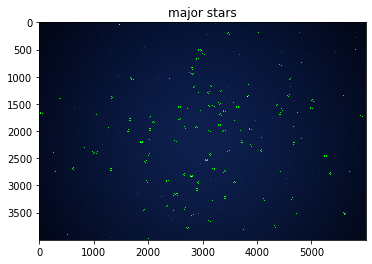

True

In [21]:
#Test and display the star coordinate finder

coords = getStarCoords(imgs[0])
starPlot = copy.deepcopy(imgs[-1])
for point in coords:
    cv2.circle(starPlot, tuple(point), 20, (0, 255, 0), thickness=3)
plt.imshow(starPlot)
plt.title("major stars")
plt.show()
starPlot = cv2.cvtColor(starPlot, cv2.COLOR_BGR2RGB)
cv2.imwrite("major_stars.png", starPlot)

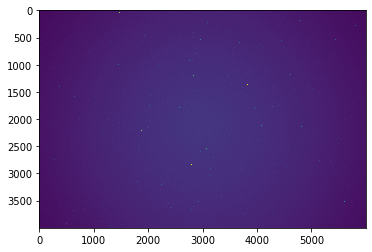

In [26]:
def getRigidTransform(pts1, pts2, numIter=8):
    '''
    Estimates a rigid body transform between two image frames. returns 3x3 homogenous matrix
    '''
    #find correspondances for each point
    
    tree = KDTree(pts1)
    _, idxs = tree.query(pts2, k=1)
    print(idxs)
    print(idxs.shape)
    pts2 = pts2[idxs]
    pts2 = pts2[:pts1.shape[0],0,:]
    centroid1 = np.mean(pts1, axis=0)
    centroid2 = np.mean(pts2, axis=0)
    pts1m = pts1 - centroid1
    pts2m = pts2 - centroid2
    H = np.matmul(pts1m.T, pts2m)
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T * U.T
    t = np.matmul(-R, centroid1) + centroid2
    rt = np.identity(3)

    rt[:2, :2] = R
    rt[:2, 2] = t
    return rt

points1 = getStarCoords(imgs[0])
points2 = getStarCoords(imgs[-1])
linePlot = copy.deepcopy(imgs[-1])
for i in range(points1.shape[0]):
    cv2.line(linePlot, tuple(points1[i]), tuple(points2[i]), (0, 255, 2), thickness=1)
# cv2.cvtColor(linePlot, cv2.COLOR_BGR2RGB)
cv2.imwrite("lines_between_coords.png", linePlot)
# print(getRigidTransform(points1, points2))
testImg = copy.deepcopy(imgs[-1])
testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2GRAY)
cv2.imwrite("first_img.png", testImg)
plt.imshow(testImg)
plt.show()

number of stars: 150
number of stars: 150
()
[3050.56 2076.52]
[[  0.95322807   0.04677193  45.55772907]
 [  0.04677193   0.95322807 -45.55772907]
 [  0.           0.           1.        ]]
